In [99]:
%load_ext sql

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import peakutils
import pandas as pd
from locate import *

from scipy import signal 
%matplotlib notebook
%sql sqlite:///schema/test.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


u'Connected: None@schema/test.db'

In [104]:
cur_experiment_id = 69
result = %sql select data from mic where experiment_id = :cur_experiment_id

mic_1 = np.array(result[0][0])
mic_2 = np.array(result[1][0])
mic_3 = np.array(result[2][0])

# Median filter the data
mic_1 = mov_median(mic_1, 51)
mic_2 = mov_median(mic_2, 51)
mic_3 = mov_median(mic_3, 51)

Done.


<IPython.core.display.Javascript object>


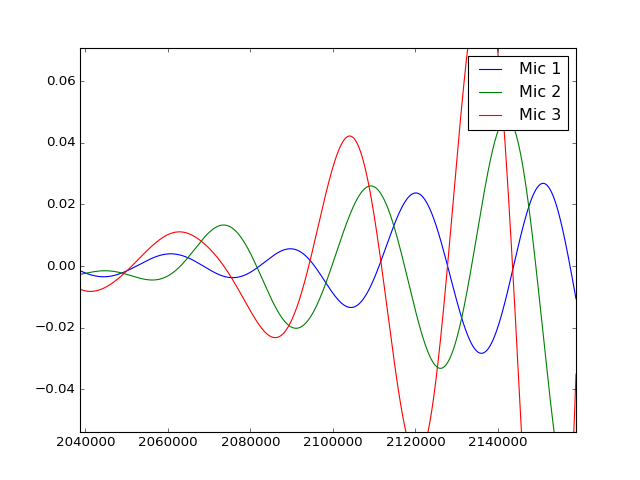

In [111]:


%matplotlib notebook
plt.figure(1)
const = 75
plt.plot(normalize_signal(apply_butter(262-const, 262+const, SAMPLING_FREQ, mic_1)), label='Mic 1', lw=1)#
plt.plot(normalize_signal(apply_butter(262-const, 262+const, SAMPLING_FREQ, mic_2)), label='Mic 2', lw=1)
plt.plot(normalize_signal(apply_butter(262-const, 262+const, SAMPLING_FREQ, mic_3)), label='Mic 3', lw=1)

#plt.plot(mic_1, label='Mic 1 orig', lw=1)
#plt.plot(mic_2, label='Mic 2', lw=1)
#plt.plot(mic_3, label='Mic 3', lw=1)
plt.legend()
plt.show()

In [102]:
sig_butter = normalize_signal(apply_butter(FREQ_1, FREQ_2, SAMPLING_FREQ, mic_1))
peakutils.peak.indexes(sig_butter, thres=0.6, min_dist=1000)

array([2314812, 2349199, 2384727, 2421690, 2459510, 2497884, 2534816,
       2570439, 2606263, 2642144, 2677583, 2713139, 2748786])

[2180280 2214861 2252145 2288874 2324680 2360308 2396153 2432007 2467920
 2504000 2540599 2577196 2613732 2650583 2687515 2724290 2760857]
[2174596 2209682 2246475 2285596 2323780 2359780 2395240 2431166 2467064
 2502713 2539241 2575940 2612574 2649893 2686900 2723236 2759476]
[2136403 2168930 2203652 2242405 2282840 2329598 2366152 2400661 2462469
 2496327 2530010 2564306 2600400 2638243 2675248 2711165 2747817 2781838]
2174596 2180280
2072280
2174596 2174596
2066596
2174596 2168930
2060930


<IPython.core.display.Javascript object>


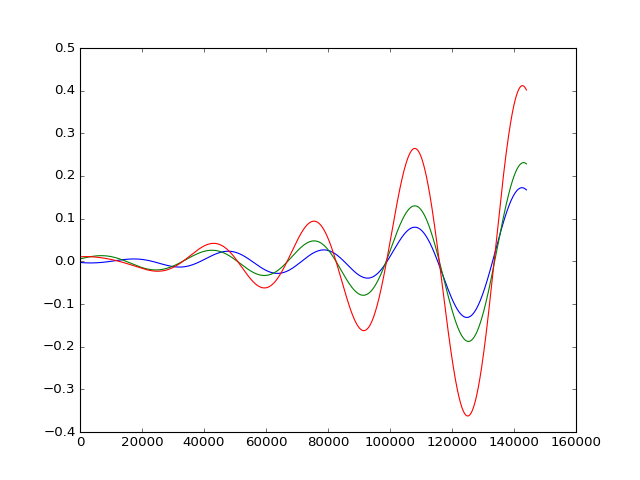

<function matplotlib.pyplot.show>

In [112]:
import locate
reload(locate)

sig1 = normalize_signal(apply_butter(262-const, 262+const, SAMPLING_FREQ, mic_1))
sig2 = normalize_signal(apply_butter(262-const, 262+const, SAMPLING_FREQ, mic_2))
sig3 = normalize_signal(apply_butter(262-const, 262+const, SAMPLING_FREQ, mic_3))

sigs = [sig1, sig2, sig3]

n = 5

MIN_PEAK_DIST = 30000
MAX_PEAK_DIST = 40000
PEAK_THRESH_HIGH = 0.05
PEAK_THRESH_LOW = 0.01

def find_first_peak(sig, peak_thresh_high, peak_thresh_low):
    idx_peak_all = peakutils.peak.indexes(sig, thres=0, min_dist=30000)
    idx_peak = np.array([i for i in idx_peak_all if sig[i] >= peak_thresh_high])
    print idx_peak
    found = False
    first_peak = 0
    while not found:
        if (first_peak > len(idx_peak) - n):
            raise RuntimeError("Could not find peak in signal")
        found = True
        for i in range(n):
            if (idx_peak[first_peak+i+1] - idx_peak[first_peak+i]) > MAX_PEAK_DIST:
                first_peak += 1
                found = False
                break;
                
    return idx_peak[first_peak], np.array([i for i in idx_peak_all if sig[i] >= peak_thresh_low])

pks = []
locations = []
for i in range(3):
    pk, locs = find_first_peak(sigs[i], PEAK_THRESH_HIGH, PEAK_THRESH_LOW)
    pks.append(pk)
    locations.append(locs)

pk_ref = min(pks)

offsets = []
sigs_cropped = []
for i in range(3):
    pk_ref_i = locate.find_nearest(locations[i], pk_ref)
    print pk_ref, pk_ref_i
    offset_i = (pk_ref_i-PEAK_WINDOW_PREFIX)
    print offset_i
    offsets.append(offsets)
    sig_i_cropped = sigs[i][offset_i:pk_ref_i+PEAK_WINDOW_SUFFIX]
    sigs_cropped.append(sig_i_cropped)


%matplotlib notebook
plt.figure(1)
plt.plot(sigs_cropped[0])
plt.plot(sigs_cropped[1])
plt.plot(sigs_cropped[2])
plt.show


In [83]:
import locate
reload(locate)

buf_crop, offsets = locate.crop_sigs(np.array(sigs))
j = 0
k = 1

locate.xcorr_peaks(buf_crop[j], buf_crop[k], offsets[j], offsets[k], 0.3)


((array([-262144, -262143, -262142, ...,  262141,  262142,  262143]),
  array([ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j])),
 -7255)

In [ ]:
"""
# Crop each signal about peaks
sig1_cropped, _ , offset1, pk1_locs = find_peak_window(sig1, thres=0.5, min_dist=1000, n=1)
sig2_cropped, _ , offset2, pk2_locs = find_peak_window(sig2, thres=0.3, min_dist=1000,
                                                           n=None, closest_to=pk1_locs)
%matplotlib notebook
plt.figure(1)
plt.plot(sig1_cropped, label='Mic 1', lw=1)
plt.plot(sig2_cropped, label='Mic 2', lw=1)
plt.legend()
plt.show()

print pk1_locs, pk2_locs
print("offset2 - offset1: %d\n" % (offset2 - offset1))
_, delay_xcor = locate.xcorr(sig1_cropped, sig2_cropped)
print "xcorr: %r\n" % (delay_xcor + (offset2 - offset1))
fs = 9.5e6
max_delay = locate.calc_max_delay(0.3)
print max_delay
corr, delay_gcc = locate.gcc_xcorr(apply_butter(FREQ_1, FREQ_2, SAMPLING_FREQ, sig1_cropped), apply_butter(FREQ_1, FREQ_2, SAMPLING_FREQ, sig2_cropped), max_delay, -(offset2 - offset1), FREQ_1, FREQ_2, fs)
print "gcc-phat: %r\n" % (delay_gcc + (offset2 - offset1))
"""


gcc-phat: -11403



<IPython.core.display.Javascript object>


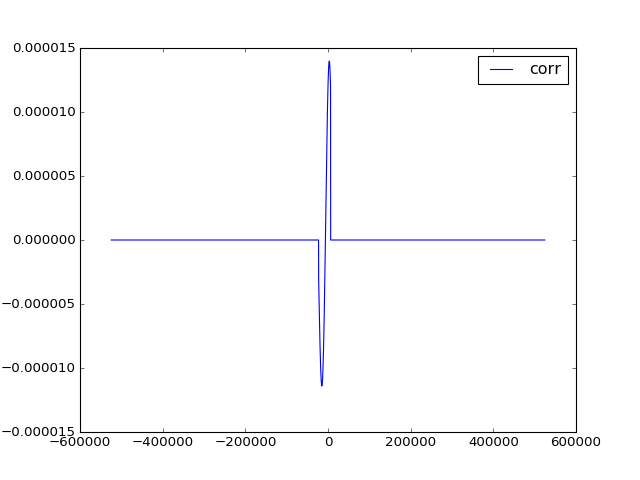

3059
-8344


/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [29]:
reload(locate)

corr, delay_gcc = locate.gcc_xcorr(sig1_cropped, sig2_cropped, max_delay, -(offset2 - offset1), FREQ_1, FREQ_2, fs)
print "gcc-phat: %r\n" % (delay_gcc + (offset2 - offset1))

%matplotlib notebook
plt.figure(1)
plt.plot(corr[0], corr[1], label='corr', lw=1)
plt.legend()
plt.show()

print corr[0][np.argmax(corr[1])]
print (offset2 - offset1)